In [194]:
import numpy as np
import pandas as pd

from skimage import io
from skimage import color
import skimage.measure
import face_recognition
import cv2
from IPython.display import SVG

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow.keras import layers
import keras

import pydotplus
from keras.utils.vis_utils import model_to_dot

import random
import math
import os

In [6]:
tf.get_logger().setLevel('ERROR')

## autoencoder

In [41]:
def encoder(t,b,l,r):
    n,m=b-t,r-l
    
    # read faces from files
    
    #blank image here (since we will have to process blank images later)
    faces=[np.ones(shape=(n*m,))*0.5]
    
    for file in os.listdir("faces"):
        face=mpimg.imread('faces/'+file)[:,:,0]
        face=cv2.resize(face,(96,96))
        face=face[t:b,l:r]
        face=face/256 #compress into [0,1]
        face+=0.5-face.mean()
        faces.append(face.reshape(-1)) #flatten
    
    faces=np.array(faces)
        
    #build autoencoder
    #it is actually just a single dense layer
    
    input_encoder=layers.Input((n*m,))
    
    #encoder
    encoded=layers.Dense(4,activation='sigmoid')(input_encoder) #latent space of 4

    encoder=keras.Model(
        inputs=[input_encoder],
        outputs=[encoded],
    )
    
    #decoder
    decoded=layers.Dense(n*m,activation='sigmoid')(encoded)

    train=keras.Model(
        inputs=[input_encoder],
        outputs=[decoded],
    )
    
    #train the autoencoder
    train.compile(
      optimizer="adam",
      loss="binary_crossentropy",
    )
    
    #do 100 epochs
    train.fit(faces,faces,validation_split=0.2,epochs=10,batch_size=8,steps_per_epoch=1000)
    
    #display some examples of autoencoder
    fig,axs=plt.subplots(3,15,figsize=(15,3))
    
    for x in axs.ravel():
        x.axis('off')

    pred=train.predict(faces[:10])
    pred2=encoder.predict(faces[:10])

    for i in range(10):
        axs[0,i].imshow(faces[i].reshape(n,m)) #in
        axs[2,i].imshow(pred[i].reshape(n,m)) #out
        axs[1,i].imshow(pred2[i].reshape(2,2)) #latent space
        
    #get decoder
    train.get_weights()
    
    inp=layers.Input(4)
    dense=layers.Dense(n*m)(inp)
    
    decoder=keras.Model(
        inputs=[inp],
        outputs=[dense],
    )
    decoder.set_weights(train.get_weights()[2:])
    
    temp=np.array([ #hardcoding
        [0,0,0,0],
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,0],
        [0,0,0,1]
    ])
    
    #show each parameter of the latent layer
    pred=decoder.predict(temp)
    
    for i in range(5):
        axs[2,i+10].imshow(pred[i].reshape(n,m)) #out
        axs[1,i+10].imshow(temp[i].reshape(2,2)) #latent space
    
    #return encoder and converter for use later
    return encoder,train

Epoch 1/10
1000/1000 [==============================] - 2s 1ms/step - loss: 0.6822 - val_loss: 0.6680
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6662 - val_loss: 0.6621
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6604 - val_loss: 0.6596
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6591 - val_loss: 0.6575
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6562 - val_loss: 0.6561
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6552 - val_loss: 0.6552
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6549 - val_loss: 0.6546
Epoch 8/10
1000/1000 [==============================] - 1s 801us/step - loss: 0.6543 - val_loss: 0.6547


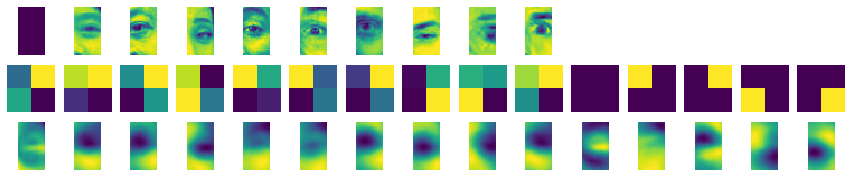

In [101]:
encode_eye,conv_eye=encoder(4,48,56,80)

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6865 - val_loss: 0.6755
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6733 - val_loss: 0.6708
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6689 - val_loss: 0.6684
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6665 - val_loss: 0.6671
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6653 - val_loss: 0.6664
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6640 - val_loss: 0.6657
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6641 - val_loss: 0.6654
Epoch 8/10
1000/1000 [==============================] - 1s 780us/step - loss: 0.6641 - val_loss: 0.6652


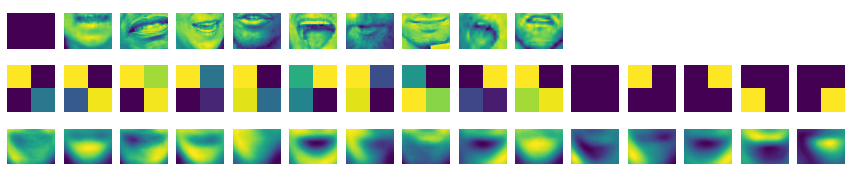

In [99]:
encode_mouth,conv_mouth=encoder(60,96,24,72)

In [65]:
def get_img(id):
    return mpimg.imread('thumbs/'+id+'.jpg')

In [77]:
def get_face(id,num):
    if (os.path.isfile('faces/'+id+'_'+str(num)+'.jpg')): return mpimg.imread('faces/'+id+'_'+str(num)+'.jpg')
    else: return np.ones((120,120,3),dtype='uint8')*128

In [24]:
df=pd.read_csv('scraping youtube/metadata.csv',index_col=0)

In [25]:
df=df.T
df=df.reset_index(drop=True)

In [26]:
df.head()

title            views  \
0  Veterans' Voices 2020: General Joseph Votel, U...     22,540 views   
1                       How To Make Tandoori Chicken  1,724,176 views   
2  25 Airbag Rainbow Explosion in 4K - The Slow M...  6,431,213 views   
3    Hunting The SECRET MEGALODON BOSS In Minecraft!    457,053 views   
4    Maroon 5 - Don't Wanna Know (Behind The Scenes)  1,050,911 views   

           likes        dislikes  \
0       92 likes     28 dislikes   
1   93,482 likes  7,647 dislikes   
2  185,758 likes  1,712 dislikes   
3   12,111 likes    386 dislikes   
4   27,807 likes    287 dislikes   

                                                desc           id clickbait  
0  Veterans served their nation selflessly, but s...  K15jFOVrAy4         0  
1  Today I show you how to make authentic Tandoor...  lG3PEdw0xrU         1  
2  Sometimes ideas get too big for our backyard s...  0vUgGSLTtOg         0  
3  If you enjoyed this video, watch more here: ht...  d17H1uhfYjw         1  
4  Buy “Don't Wanna Know" ft. Kendrick LaMar now....  KTF1Nqvl8ug         0

In [27]:
df2=pd.read_csv('human acc/metadata.csv',index_col=0)

In [28]:
df2=df2.T
df2=df2.reset_index(drop=True)

In [29]:
df2.head()

title             views  \
0  Disturbing images of civilian killings in Ethi...     286,650 views   
1                                  Barcoders Jamming   4,636,323 views   
2                      Illegal Numbers - Numberphile   3,090,182 views   
3  HUNTERS vs SPEEDRUNNER With PORTAL GUNS! (Mine...     752,038 views   
4                          Worst Juicer Ever Created  10,975,198 views   

           likes        dislikes  \
0    4,195 likes    496 dislikes   
1  332,382 likes  3,953 dislikes   
2   46,394 likes  1,237 dislikes   
3   54,402 likes    568 dislikes   
4  342,019 likes  4,249 dislikes   

                                                desc           id clickbait  
0  Disturbing videos which appear to show the kil...  ZDSHgitOTcI         0  
1  Barcoders Jamming!\nBarcoder: generates sounds...  bOfpQt4KFCc         0  
2  Brown papers auction: http://bit.ly/brownpaper...  wo19Y4tw0l8         1  
3  ⭐️ HUNTERS vs SPEEDRUNNER With PORTAL GUNS!\n😎...  O8hXw43oi9E         1  
4    This is the greatest waste of money of All Time  PCRx78Zhj7s         0

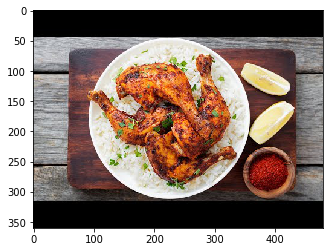

In [30]:
plt.imshow(get_img(df["id"][1]))

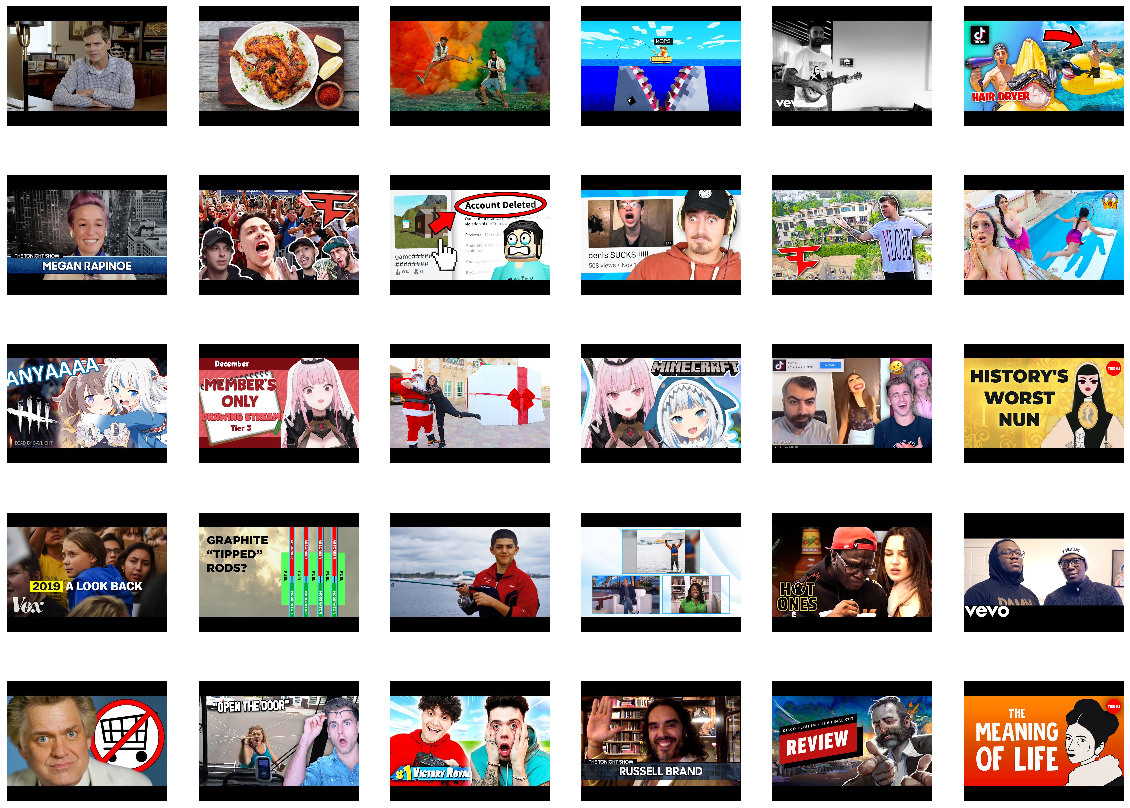

In [31]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        axs[i,j].imshow(get_img(df["id"][i*6+j]))

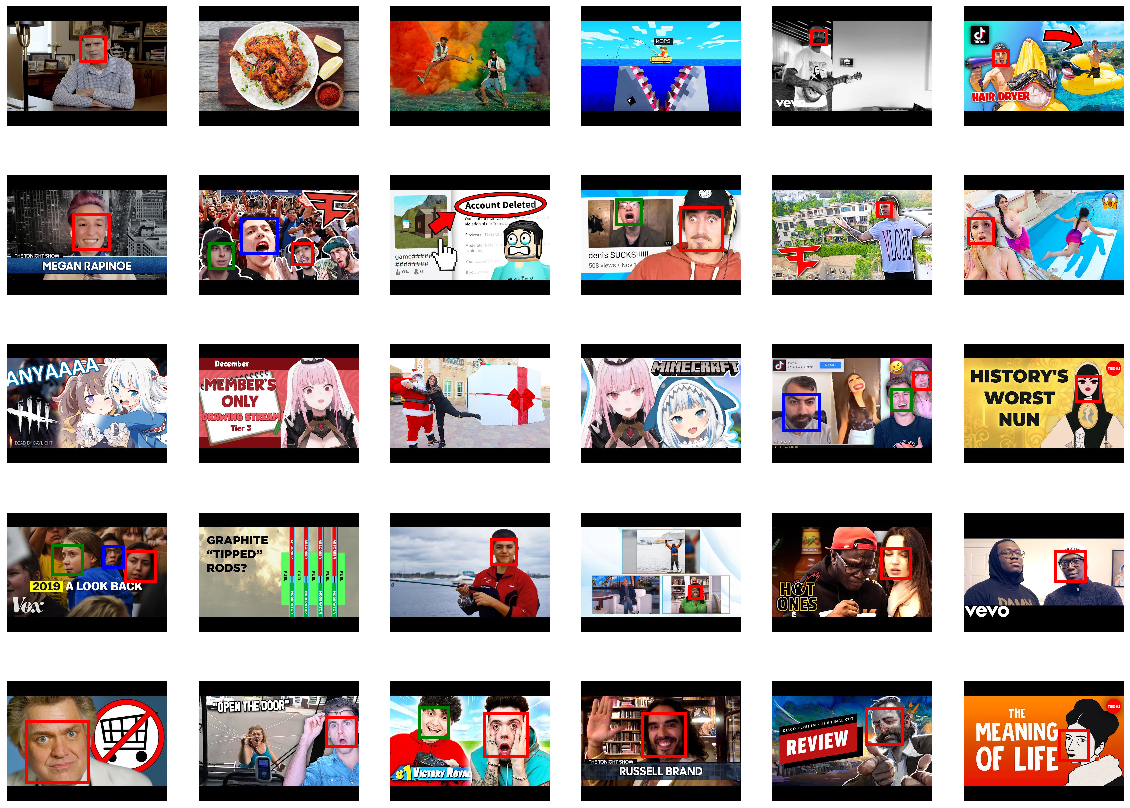

In [32]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        img=get_img(df["id"][i*6+j])
        axs[i,j].imshow(img)
        
        locs=face_recognition.face_locations(img)
        
        for x in range(min(3,len(locs))):
            t,r,b,l=locs[x]
            
            rect=patches.Rectangle((l,t),r-l,b-t,linewidth=3,edgecolor="rgb"[x],facecolor='none')
            axs[i,j].add_patch(rect)

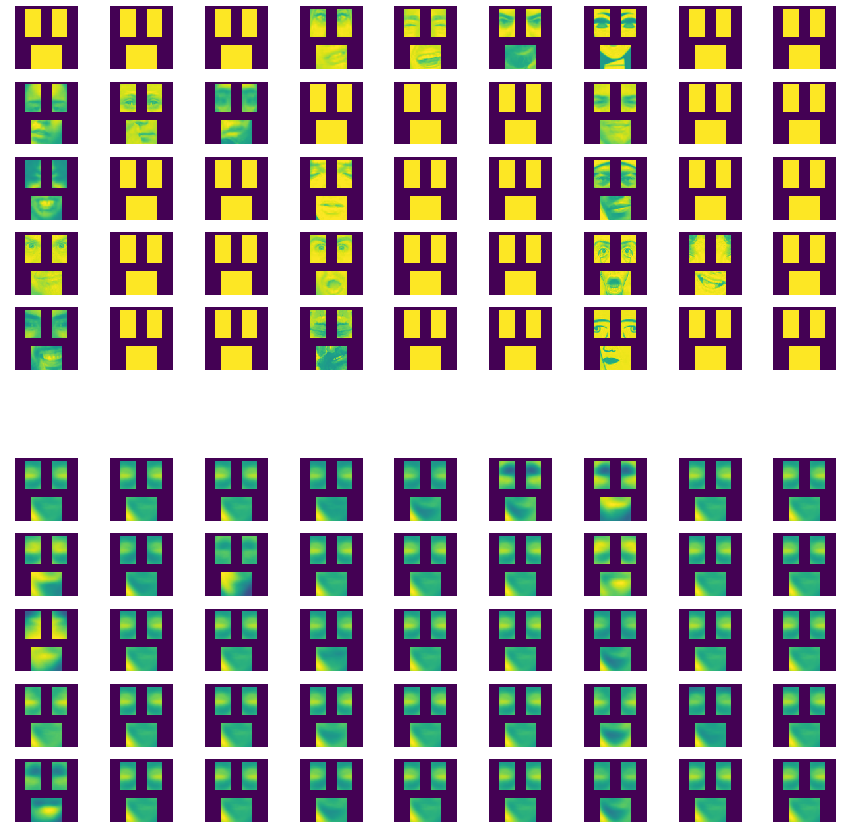

In [103]:
fig,axs=plt.subplots(11,9,figsize=(15,15))

for x in axs.ravel():
    x.axis('off')

for i in range(15):
    for j in range(3):
        img=get_face(df["id"][i+15],j)[:,:,0]
        img=cv2.resize(img,(96,96))
        img=img/256
        img+=0.5+img.mean()
        
        face_i=np.zeros((96,96))
        face=np.zeros((96,96))
        
        eye_i=img[4:48,56:80]
        face_i[4:48,56:80]=eye_i
        face_i[4:48,96-80:96-56]=eye_i[:,::-1]
        
        eye=conv_eye.predict(eye_i.reshape(1,44*24))[0].reshape(44,24)
        face[4:48,56:80]=eye
        face[4:48,96-80:96-56]=eye[:,::-1]
        
        
        mouth_i=img[60:96,24:72]
        face_i[60:96,24:72]=mouth_i
        
        mouth=conv_mouth.predict(mouth_i.reshape(1,36*48))[0].reshape(36,48)
        face[60:96,24:72]=mouth
        
        
        axs[i//3][i%3*3+j].imshow(face_i)
        axs[i//3+6][i%3*3+j].imshow(face)

In [248]:
def get_io(df):
    dummy=np.ones((36,36,3))*0.5

    thumb=[]
    face=[]

    for id in df["id"]:
        img=get_img(id)[44:314]
        img=skimage.measure.block_reduce(img,(10,10,1),np.sum)
        thumb.append(img/25600)
        
        p=dummy
        
        p=np.random.permutation(3)
        for i in range(3):
            img=get_face(id,p[i])[:,:,0]
            img=cv2.resize(img,(96,96))
            img=img/256
            img+=0.5+img.mean()
            
            eye=img[4:48,56:80]
            face.append(encode_eye(eye.reshape(1,44*24)))
            
            mouth=img[60:96,24:72]
            face.append(encode_mouth(mouth.reshape(1,36*48)))
                
    train={
        "thumb":np.array(thumb),
        "face":np.array(face).reshape(-1,24)
    }
    
    test=np.array(df["clickbait"].astype(int))
    
    return train,test

In [249]:
X_train,y_train=get_io(df)
X_test,y_test=get_io(df2)

In [251]:
def visualize_model(model):
  return SVG(model_to_dot(model,show_shapes=True,dpi='50').create(prog='dot', format='svg'))

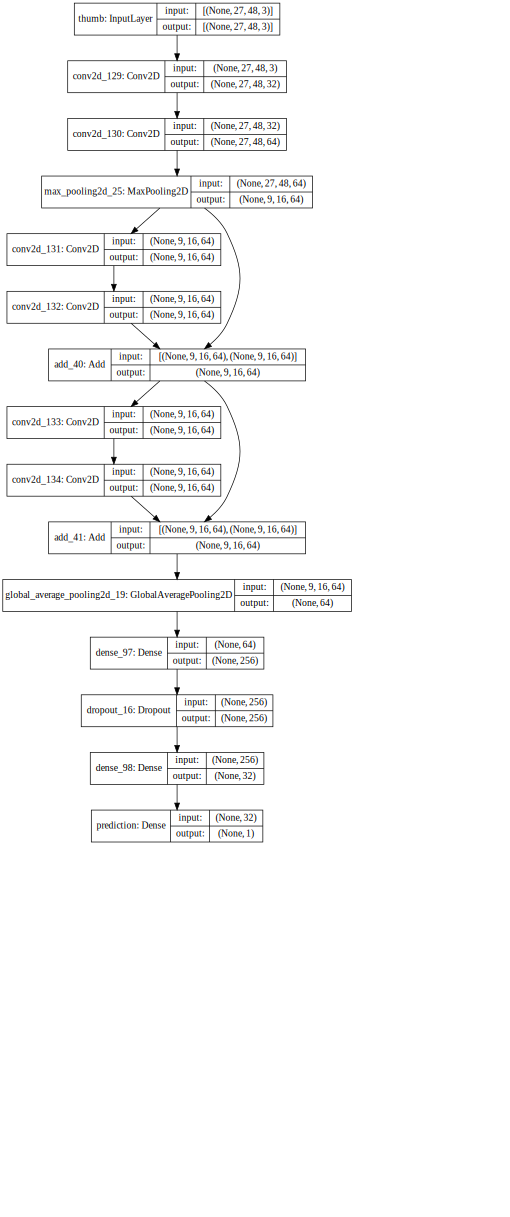

In [296]:
thumbnail_input=keras.Input(shape=(27,48,3),name='thumb')

#2d conv for thumbnail
conv0_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(thumbnail_input)
conv1_thumb=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(3,3),strides=(3,3))(conv1_thumb)

x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(pool)
x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(x)
block0_thumb=layers.add([x,pool])

x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(block0_thumb)
x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(x)
block1_thumb=layers.add([x,block0_thumb])

flat=layers.GlobalAveragePooling2D()(block1_thumb)

dense0=layers.Dense(256,activation='relu')(flat)
dropout=layers.Dropout(rate=0.5)(dense0)
dense1=layers.Dense(32,activation='relu')(dropout)
pred=layers.Dense(1,activation='sigmoid',name="prediction")(dense1)

model = keras.Model(
    inputs=[thumbnail_input],
    outputs=pred,
)

visualize_model(model)

In [297]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=['accuracy']
)

In [298]:
model.fit(X_train["thumb"],y_train,validation_data=(X_test["thumb"],y_test),epochs=5,batch_size=256)

Epoch 1/5
39/39 [==============================] - 44s 1s/step - loss: 0.6885 - accuracy: 0.5507 - val_loss: 0.7022 - val_accuracy: 0.3588
Epoch 2/5
39/39 [==============================] - 39s 982ms/step - loss: 0.6442 - accuracy: 0.5910 - val_loss: 0.6560 - val_accuracy: 0.5471
Epoch 3/5
39/39 [==============================] - 37s 948ms/step - loss: 0.6216 - accuracy: 0.6390 - val_loss: 0.6124 - val_accuracy: 0.6706
Epoch 4/5
39/39 [==============================] - 41s 1s/step - loss: 0.6160 - accuracy: 0.6543 - val_loss: 0.6310 - val_accuracy: 0.6294
Epoch 5/5
39/39 [==============================] - 35s 900ms/step - loss: 0.5596 - accuracy: 0.7125 - val_loss: 0.8637 - val_accuracy: 0.4235


In [294]:
model.evaluate(X_test["thumb"],y_test)

6/6 [==============================] - 0s 30ms/step - loss: 0.6978 - accuracy: 0.6412


[0.6977710127830505, 0.6411764621734619]

In [295]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test["thumb"])
y_pred_bool=y_pred>0.5

print(classification_report(y_test,y_pred_bool))
print(confusion_matrix(y_test,y_pred_bool))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       124
           1       0.41      0.70      0.51        46

    accuracy                           0.64       170
   macro avg       0.63      0.66      0.61       170
weighted avg       0.73      0.64      0.66       170

[[77 47]
 [14 32]]


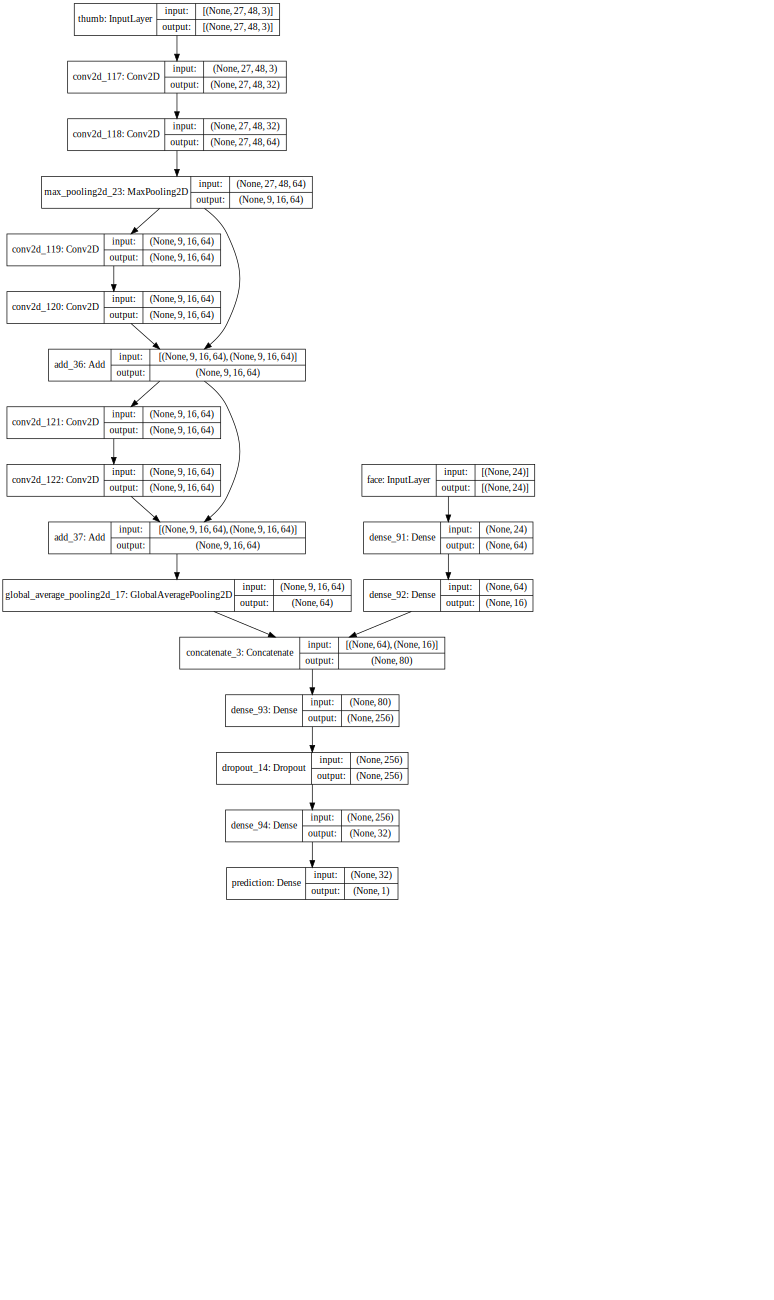

In [266]:
thumbnail_input=keras.Input(shape=(27,48,3),name='thumb') #all thumbnails have size 360x480

#2d conv for thumbnail
conv0_thumb=layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(thumbnail_input)
conv1_thumb=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(conv0_thumb)
pool=layers.MaxPooling2D(pool_size=(3,3),strides=(3,3))(conv1_thumb)

x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(pool)
x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(x)
block0_thumb=layers.add([x,pool])

x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(block0_thumb)
x=layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(x)
block1_thumb=layers.add([x,block0_thumb])

flat=layers.GlobalAveragePooling2D()(block1_thumb)


#face inputs
face_input=keras.Input(shape=(24),name="face")
    
dense0_face=layers.Dense(64,activation='relu')(face_input)
dense1_face=layers.Dense(16,activation='relu')(dense0_face)
    
concat=layers.concatenate([flat,dense1_face])

dense0=layers.Dense(256,activation='relu')(concat)
dropout=layers.Dropout(rate=0.5)(dense0)
dense1=layers.Dense(32,activation='relu')(dropout)
pred=layers.Dense(1,activation='sigmoid',name="prediction")(dense1)

model = keras.Model(
    inputs=[thumbnail_input,face_input],
    outputs=pred,
)

visualize_model(model)

In [267]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=['accuracy']
)

In [268]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=50) #double block

Epoch 1/5
195/195 [==============================] - 44s 223ms/step - loss: 0.6740 - accuracy: 0.5709 - val_loss: 0.6096 - val_accuracy: 0.7059
Epoch 2/5
195/195 [==============================] - 47s 241ms/step - loss: 0.5876 - accuracy: 0.6916 - val_loss: 0.6182 - val_accuracy: 0.7000
Epoch 3/5
195/195 [==============================] - 55s 284ms/step - loss: 0.5439 - accuracy: 0.7236 - val_loss: 0.5752 - val_accuracy: 0.7118
Epoch 4/5
195/195 [==============================] - 53s 273ms/step - loss: 0.5052 - accuracy: 0.7524 - val_loss: 0.6674 - val_accuracy: 0.6824
Epoch 5/5
195/195 [==============================] - 52s 268ms/step - loss: 0.4610 - accuracy: 0.7732 - val_loss: 0.5832 - val_accuracy: 0.7412


In [269]:
model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 25ms/step - loss: 0.5832 - accuracy: 0.7412


[0.5832322239875793, 0.7411764860153198]

In [287]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred=model.predict(X_test)
y_pred_bool=y_pred>0.5

print(classification_report(y_test,y_pred_bool))
print(confusion_matrix(y_test,y_pred_bool))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       124
           1       0.31      0.33      0.32        46

    accuracy                           0.62       170
   macro avg       0.53      0.53      0.53       170
weighted avg       0.63      0.62      0.63       170

[[91 33]
 [31 15]]


In [273]:
lol=model.predict(X_train)

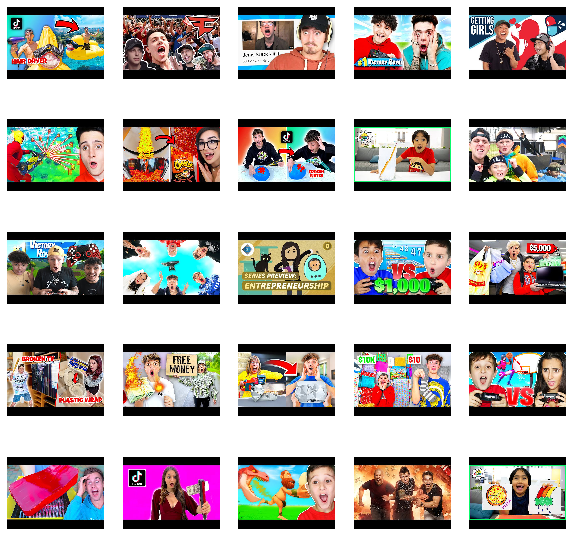

In [277]:
fig,axs=plt.subplots(5,5,figsize=(10,10))

for x in axs.ravel():
    x.axis("off")

curr=0
for i in range(1000):
    if (lol[i]>0.9):
        axs[curr//5][curr%5].imshow(get_img(df["id"][i]))
        curr+=1
        
        if(curr==25): break

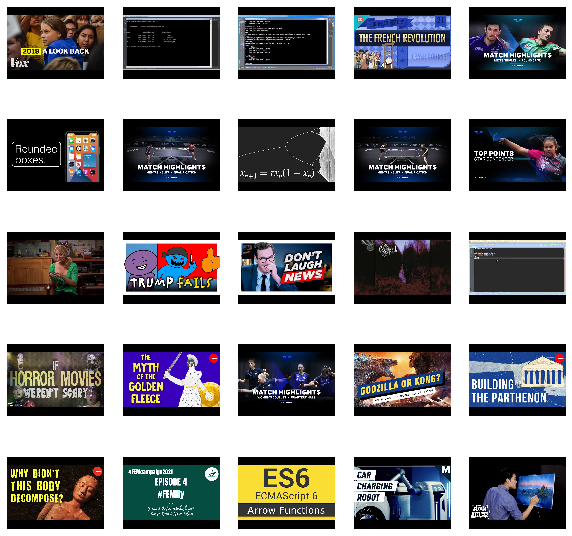

In [276]:
fig,axs=plt.subplots(5,5,figsize=(10,10))

for x in axs.ravel():
    x.axis("off")

curr=0
for i in range(1000):
    if (lol[i]<0.1):
        axs[curr//5][curr%5].imshow(get_img(df["id"][i]))
        curr+=1
        
        if(curr==25): break